In milestone 4, the main objective is to develope a model which can predict the Malaysia Ringgit exchange rate in USD for the next 10 days. To fulfill the purpose, top 150 companies stock price were used for the forecasting. Since the exchange rate and the stock price data were in separate tables, it must be first integrated into a single table for developing the model. The model would take 1 year data for training and aimed to predict next 10 days exchange rate.

In [1]:
import pandas as pd
# load currency data
myr_df = pd.read_csv("./cleaned_data/myr.csv", parse_dates = ["date"])

In [2]:
# load one company stock price data
company_df = pd.read_csv("./cleaned_data/companies/7_Eleven.csv", parse_dates = ["Date"])
company_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1235 non-null   datetime64[ns]
 1   Price   1235 non-null   float64       
 2   Open    1235 non-null   float64       
 3   High    1235 non-null   float64       
 4   Low     1235 non-null   float64       
 5   Vol.    1235 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 58.0 KB


In [3]:
# integrate all 150 companies stock price into one dataframe
import glob
from datetime import datetime, timedelta
import os
# grab all csv files in the data storage
csv_files = glob.glob("./cleaned_data/companies/*.csv")
# initiate the dataframe for integration
full_df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.read_csv(csv_file, parse_dates=["Date"])
    # filter 1 year data for training
    cut_off_date = datetime.strptime("2020-01-30", "%Y-%m-%d").date()
    df_year = df.loc[(df.Date.dt.date >= (cut_off_date - timedelta(days = 365))) & (df.Date.dt.date < cut_off_date), 
                     ["Date", "Price"]]
    basename = os.path.basename(csv_file)
    basename = basename[: basename.find(".csv")]
    df_year.rename(columns = {"Price": basename}, inplace = True)
    if full_df.empty:
        full_df = pd.concat([full_df, df_year], axis = 1)
    else:
        full_df = full_df.merge(df_year, on = "Date", how = "outer")
    
    

In [4]:
print("Number of column with missing data: {}".format(full_df.isna().any().sum()))

Number of column with missing data: 39


The missing data is due to some missing date for a few of the stock prices. For the ease of model training at later stage, missing value is filled with KNN method.

In [5]:
from sklearn.impute import KNNImputer
imp = KNNImputer(n_neighbors = 3)
column_name = full_df.drop("Date", axis = 1).columns.tolist()
prices = full_df.drop("Date", axis = 1).values
prices = imp.fit_transform(prices)

In [6]:
stock_df = pd.DataFrame(prices, columns = column_name)
stock_df = pd.concat([full_df.Date, stock_df], axis = 1)
print("Number of column with missing data: {}".format(stock_df.isna().any().sum()))

Number of column with missing data: 0


In [7]:
# match date of currency dataframe with stock price dataframe
myrm_df = myr_df.loc[myr_df["date"].dt.date.isin(stock_df["Date"].dt.date), :]
# integrate currency dataframe with stock price dataframe
final_df = myrm_df.merge(stock_df, how = "left", left_on = "date", right_on = "Date")
final_df.rename(columns = {"USD": "exchange_rate"}, inplace = True)
final_df.sort_values("date", inplace = True, ascending = True)
final_df.head()

,date,exchange_rate,Date,7_Eleven,AEON_Co,Aeon_Credit_Service,AFFIN,Airasia,Alliance_Bank_Malaysia,Allianz_Malaysia,...,Uwc,Velesto_Energy,ViTrox_Corp,VS_Industry_Bhd,Westports,Yinson,YNH_Property,YTL_Corp,YTL_Hospitality_REIT,YTL_Power_Int
6,2019-01-30,4.1090,2019-01-30,1.394,1.50,15.76,2.21,2.087,4.22,13.48,...,0.886667,0.200,6.65,0.800,3.70,4.15,1.30,1.15,1.26,0.885
7,2019-01-31,4.0890,2019-01-31,1.394,1.55,15.96,2.21,2.080,4.24,13.44,...,0.886667,0.190,6.69,0.810,3.72,4.10,1.27,1.10,1.27,0.900
42,2019-02-04,4.0835,2019-02-04,1.394,1.57,16.02,2.20,2.148,4.18,13.48,...,0.886667,0.185,6.65,0.815,3.75,4.08,1.26,1.11,1.26,0.905
93,2019-02-07,4.1420,2019-02-07,1.394,1.55,16.20,2.23,2.142,4.33,13.46,...,0.886667,0.195,6.60,0.845,3.82,4.08,1.33,1.15,1.27,0.905
111,2019-02-08,4.1540,2019-02-08,1.394,1.55,16.20,2.23,2.135,4.24,13.28,...,0.886667,0.195,6.57,0.840,3.83,4.10,1.26,1.15,1.27,0.905


In [8]:
final_df.isna().any().sum()

0

In [9]:
final_df["future_rate"] = final_df.exchange_rate.shift(10)
final_df[["exchange_rate", "future_rate"]].head(15)

,exchange_rate,future_rate
6,4.1090,NaN
7,4.0890,NaN
42,4.0835,NaN
93,4.1420,NaN
111,4.1540,NaN
179,4.1795,NaN
12,4.0650,NaN
13,4.0630,NaN
14,4.0805,NaN
15,4.0785,NaN


The data is prepared for predicting future exchange rate for the next 10 trading days. Therefore, the current exchange rate is shifted to 10 days later. For the purpose of training the model, the first 10 days of the data will be dropped from the dataframe next. 

In [10]:
# drop the first 10 rows with NA (future exchange rate)
final_df.dropna(inplace = True)
# drop addition date column
final_df.drop("Date", axis = 1, inplace = True)

In [11]:
final_df

,date,exchange_rate,7_Eleven,AEON_Co,Aeon_Credit_Service,AFFIN,Airasia,Alliance_Bank_Malaysia,Allianz_Malaysia,AMMB,...,Velesto_Energy,ViTrox_Corp,VS_Industry_Bhd,Westports,Yinson,YNH_Property,YTL_Corp,YTL_Hospitality_REIT,YTL_Power_Int,future_rate
16,2019-02-19,4.0880,1.423,1.51,16.76,2.29,2.018,4.17,13.44,4.42,...,0.235,6.98,0.940,4.00,4.19,1.26,1.080,1.27,0.905,4.1090
17,2019-02-20,4.0695,1.423,1.54,17.00,2.31,2.148,4.19,13.68,4.45,...,0.260,6.98,1.000,3.94,4.21,1.25,1.150,1.27,0.925,4.0890
18,2019-02-21,4.0695,1.423,1.54,16.94,2.30,2.251,4.25,13.88,4.55,...,0.240,6.95,1.020,3.89,4.27,1.25,1.160,1.29,0.930,4.0835
19,2019-02-22,4.0825,1.423,1.57,17.00,2.31,2.142,4.25,14.35,4.58,...,0.230,6.82,0.985,3.87,4.26,1.24,1.150,1.29,0.915,4.1420
20,2019-02-25,4.0705,1.423,1.59,16.88,2.30,2.100,4.25,14.33,4.55,...,0.245,6.69,1.010,3.84,4.30,1.24,1.140,1.29,0.905,4.1540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2020-01-22,4.0735,1.390,1.43,13.06,1.86,1.610,2.49,15.64,3.82,...,0.370,9.24,1.490,4.00,6.23,2.73,0.980,1.36,0.790,4.1315
206,2020-01-23,4.0655,1.390,1.41,13.00,1.89,1.610,2.45,15.74,3.84,...,0.365,9.33,1.480,4.10,6.23,2.70,0.990,1.36,0.790,4.1135
207,2020-01-24,4.0645,1.380,1.38,13.06,1.88,1.560,2.47,14.86,3.83,...,0.360,9.30,1.490,4.06,6.20,2.71,0.980,1.36,0.785,4.0925
208,2020-01-28,4.0835,1.390,1.36,13.26,1.86,1.500,2.42,14.34,3.77,...,0.350,9.20,1.440,4.00,6.22,2.70,0.940,1.35,0.785,4.0645


In [12]:
final_df.set_index("date", inplace = True)
final_df.head()

,exchange_rate,7_Eleven,AEON_Co,Aeon_Credit_Service,AFFIN,Airasia,Alliance_Bank_Malaysia,Allianz_Malaysia,AMMB,Astro_Malaysia,...,Velesto_Energy,ViTrox_Corp,VS_Industry_Bhd,Westports,Yinson,YNH_Property,YTL_Corp,YTL_Hospitality_REIT,YTL_Power_Int,future_rate
date,,,,,,,,,,,,,,,,,,,,,
2019-02-19,4.0880,1.423,1.51,16.76,2.29,2.018,4.17,13.44,4.42,1.64,...,0.235,6.98,0.940,4.00,4.19,1.26,1.08,1.27,0.905,4.1090
2019-02-20,4.0695,1.423,1.54,17.00,2.31,2.148,4.19,13.68,4.45,1.66,...,0.260,6.98,1.000,3.94,4.21,1.25,1.15,1.27,0.925,4.0890
2019-02-21,4.0695,1.423,1.54,16.94,2.30,2.251,4.25,13.88,4.55,1.66,...,0.240,6.95,1.020,3.89,4.27,1.25,1.16,1.29,0.930,4.0835
2019-02-22,4.0825,1.423,1.57,17.00,2.31,2.142,4.25,14.35,4.58,1.65,...,0.230,6.82,0.985,3.87,4.26,1.24,1.15,1.29,0.915,4.1420
2019-02-25,4.0705,1.423,1.59,16.88,2.30,2.100,4.25,14.33,4.55,1.64,...,0.245,6.69,1.010,3.84,4.30,1.24,1.14,1.29,0.905,4.1540


Since we are using XG-boost (tree-based) for the model training, we do not need to normalized the data. Next we will separate the test data (the last 10 days) from the training data.

In [13]:
# extract target data from the data frame
y = final_df[["future_rate"]].copy()
X = final_df.drop("future_rate", axis = 1)
# separate test data from training data
train_X = X[:-10].copy()
train_y = y[:-10].copy()
test_X = X[-10:].copy()
test_y = y[-10:].copy()

In [14]:
train_X

,exchange_rate,7_Eleven,AEON_Co,Aeon_Credit_Service,AFFIN,Airasia,Alliance_Bank_Malaysia,Allianz_Malaysia,AMMB,Astro_Malaysia,...,Uwc,Velesto_Energy,ViTrox_Corp,VS_Industry_Bhd,Westports,Yinson,YNH_Property,YTL_Corp,YTL_Hospitality_REIT,YTL_Power_Int
date,,,,,,,,,,,,,,,,,,,,,
2019-02-19,4.0880,1.423,1.51,16.76,2.29,2.018,4.17,13.44,4.42,1.64,...,0.886667,0.235,6.98,0.940,4.00,4.19,1.26,1.08,1.27,0.905
2019-02-20,4.0695,1.423,1.54,17.00,2.31,2.148,4.19,13.68,4.45,1.66,...,0.886667,0.260,6.98,1.000,3.94,4.21,1.25,1.15,1.27,0.925
2019-02-21,4.0695,1.423,1.54,16.94,2.30,2.251,4.25,13.88,4.55,1.66,...,0.886667,0.240,6.95,1.020,3.89,4.27,1.25,1.16,1.29,0.930
2019-02-22,4.0825,1.423,1.57,17.00,2.31,2.142,4.25,14.35,4.58,1.65,...,0.886667,0.230,6.82,0.985,3.87,4.26,1.24,1.15,1.29,0.915
2019-02-25,4.0705,1.423,1.59,16.88,2.30,2.100,4.25,14.33,4.55,1.64,...,0.886667,0.245,6.69,1.010,3.84,4.30,1.24,1.14,1.29,0.905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,4.1315,1.430,1.43,14.34,1.91,1.710,2.61,15.66,3.96,1.29,...,2.150000,0.380,7.94,1.370,4.15,6.49,2.77,0.90,1.35,0.770
2019-12-30,4.1135,1.420,1.42,14.24,1.91,1.700,2.63,15.98,3.94,1.29,...,2.130000,0.380,7.92,1.380,4.30,6.49,2.69,0.95,1.36,0.765
2019-12-31,4.0925,1.430,1.42,14.14,1.90,1.700,2.63,16.14,3.91,1.27,...,2.130000,0.380,7.92,1.340,4.21,6.48,2.72,0.98,1.36,0.770


Visualize the Malaysian Ringgit Exchange rate

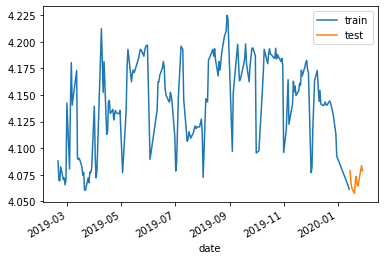

In [15]:
train_X.rename(columns = {"exchange_rate": "train"})[["train"]] \
.join(test_X.rename(columns = {"exchange_rate":"test"})[["test"]], how = "outer").plot()
                                                                                    

In [39]:
import xgboost as xgb
from xgboost import plot_importance

reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimator = 1000, max_depth=3, gamma = 100, min_child_weight = 3,
                      learning_rate = 0.1, reg_alpha = 15, reg_lambda = 5)
reg.fit(train_X, train_y,
       eval_set=[(train_X, train_y), (test_X, test_y)],
       verbose = True)

[0]	validation_0-rmse:3.29688	validation_1-rmse:3.26948
[1]	validation_0-rmse:2.98339	validation_1-rmse:2.95599
[2]	validation_0-rmse:2.70046	validation_1-rmse:2.67303
[3]	validation_0-rmse:2.4451	validation_1-rmse:2.41766
[4]	validation_0-rmse:2.21462	validation_1-rmse:2.18716
[5]	validation_0-rmse:2.00661	validation_1-rmse:1.97914
[6]	validation_0-rmse:1.81888	validation_1-rmse:1.79138
[7]	validation_0-rmse:1.64945	validation_1-rmse:1.62193
[8]	validation_0-rmse:1.49653	validation_1-rmse:1.46899
[9]	validation_0-rmse:1.35853	validation_1-rmse:1.33096
[10]	validation_0-rmse:1.23399	validation_1-rmse:1.20638
[11]	validation_0-rmse:1.12159	validation_1-rmse:1.09395
[12]	validation_0-rmse:1.02016	validation_1-rmse:0.992483
[13]	validation_0-rmse:0.928625	validation_1-rmse:0.90091
[14]	validation_0-rmse:0.846026	validation_1-rmse:0.818269
[15]	validation_0-rmse:0.771493	validation_1-rmse:0.743691
[16]	validation_0-rmse:0.704241	validation_1-rmse:0.676391
[17]	validation_0-rmse:0.643562	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=100,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=None, n_estimator=1000,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=15,
             reg_lambda=5, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [40]:
reg.predict(test_X)

array([4.064893, 4.064893, 4.064893, 4.064893, 4.064893, 4.064893,
       4.064893, 4.064893, 4.064893, 4.064893], dtype=float32)

In [18]:
def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

In [41]:
import numpy as np
rmse(test_y, reg.predict(test_X))

0.06029219848709754

In [42]:
result_df = train_X[["exchange_rate"]].copy()
last_10days = test_X[["exchange_rate"]].copy()
last_10days["prediction"] = pd.Series(reg.predict(test_X), index = test_X.index)

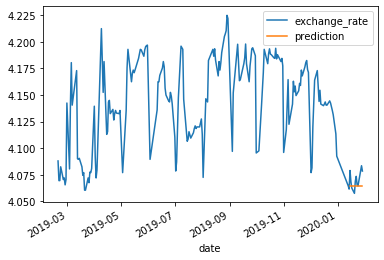

In [43]:
pd.concat([last_10days, result_df], sort = False).sort_index().plot()

In [44]:
import pickle
pickle.dump(reg, open("prediction_model.sav", "wb"))

In [45]:
new_reg = pickle.load(open("prediction_model.sav", "rb"))
new_reg.predict(test_X)

array([4.064893, 4.064893, 4.064893, 4.064893, 4.064893, 4.064893,
       4.064893, 4.064893, 4.064893, 4.064893], dtype=float32)